In [4]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt


In [ ]:
    
# import zip file with csv 
ou_zip = zipfile.ZipFile('../data/anonymisedData.zip') 

# save separate csvs
registrations = pd.read_csv(ou_zip.open('studentRegistration.csv'))
courses = pd.read_csv(ou_zip.open('courses.csv'))
students = pd.read_csv(ou_zip.open('studentInfo.csv'))
student_vle = pd.read_csv(ou_zip.open('studentVle.csv'))
vle = pd.read_csv(ou_zip.open('vle.csv'))
student_assessments = pd.read_csv(ou_zip.open('studentAssessment.csv'))
assessments = pd.read_csv(ou_zip.open('assessments.csv'))

# check basic file properties - each file

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

def csv_basics(df, exclude_columns=None, box=True):
    '''
    Function which takes dataframe and returns basic details - rows, cols, missing vals, summary stats, and optional boxplots. 
    Option to exclude columns.
    '''

    if exclude_columns:
        df = df.drop(exclude_columns, axis=1)

    num_rows = df.shape[0]
    num_columns = df.shape[1]
    print("Number of rows:", num_rows, "\n")
    print("Number of columns:", num_columns, "\n")

    missing_values = df.isnull().sum()
    print("Missing values:\n", missing_values, "\n")

    summary_stats = df.describe()
    print("Summary statistics:\n", summary_stats, "\n")

    if box:
        df.boxplot()
        plt.show()



## students

start with student info as this table already has most of the data I will be using

In terms of missing values - there is a slight concern around imd_band with 1111 missing values:

* 3.4%
* suspicion that this is not missing at random - this index can be highly sensitive and there may be a pattern to the missing responses.


TODO: in the future, more analysis on the missingness of 'imd_cat' would be interesting.  However, for the purposes of this project, I do not have the data, I cannot get the data, I do not want to impute a value (without significant additional scrutiny), I am not a domain expert...

**Decision** for the purpose of *this* report/assignment is to remove these rows.  Thereare under 5% so it is not a huge problem - but I would imagine that they may not be 'missing at random'.

The alternative is to exclude this feature from the predictive model, but I think it may have value - this could be an alternate version of the model.

Initial attempts at understanding missingness can be found in [working_file: data_missingness](/code/100_data_missingness.ipynb)

Data needs scaling - vastly different scales between `num_of_prev_attempts` and `studied_credits`


Number of rows: 32593 

Number of columns: 11 

Missing values:
 code_module                0
code_presentation          0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64 

Summary statistics:
        num_of_prev_attempts  studied_credits
count          32593.000000     32593.000000
mean               0.163225        79.758691
std                0.479758        41.071900
min                0.000000        30.000000
25%                0.000000        60.000000
50%                0.000000        60.000000
75%                0.000000       120.000000
max                6.000000       655.000000 



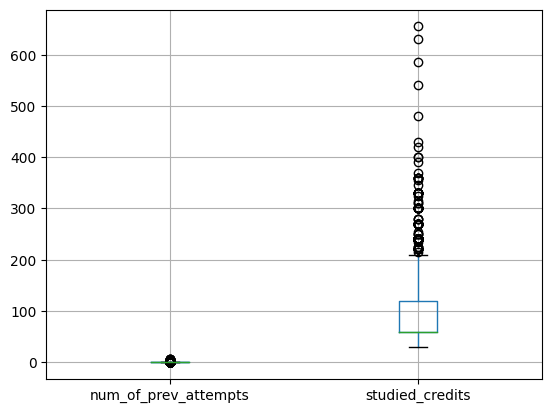

In [53]:
csv_basics(students, exclude_columns="id_student")

## registrations

~~TODO: investigate registration dates.~~
Why do 45 not have a registration date?
Unregistered before registered?
Unregistration - probably fine to leave, unless transform to - current, withdrawn, finished, or similar.

TODO: drop 45 without registration date
TODO: decide if removing unregistered before registered (on the day) or + 14 day cool off period (445 students) - probably this.



Number of rows: 32593 

Number of columns: 4 

Missing values:
 code_module                0
code_presentation          0
date_registration         45
date_unregistration    22521
dtype: int64 

Summary statistics:
        date_registration  date_unregistration
count       32548.000000         10072.000000
mean          -69.411300            49.757645
std            49.260522            82.460890
min          -322.000000          -365.000000
25%          -100.000000            -2.000000
50%           -57.000000            27.000000
75%           -29.000000           109.000000
max           167.000000           444.000000 



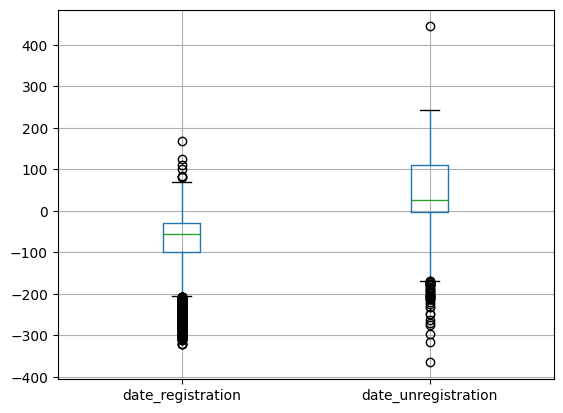

In [54]:
csv_basics(registrations, exclude_columns="id_student")

In [66]:


# unregistration before or on the same day as registration
registrations['unregistration_before_registration'] = registrations['date_unregistration'] <= registrations['date_registration']

# print unreg <= reg rows
unreg_before_reg = registrations[registrations['unregistration_before_registration'] == True]
#print(unreg_before_reg.head(20))

# unregistration before registration date + 14 (two weeks cool off)
registrations['unregistration_before_registration_14_days'] = registrations['date_unregistration'] <= registrations['date_registration'] + 14

# print unreg <= reg rows
unreg_before_reg_14_days = registrations[registrations['unregistration_before_registration_14_days'] == True]
#print(unreg_before_reg_14_days.head(20))
print(unreg_before_reg_14_days.count())

code_module                                   447
code_presentation                             447
id_student                                    447
date_registration                             447
date_unregistration                           447
unregistration_before_registration            447
unregistration_before_registration_14_days    447
dtype: int64


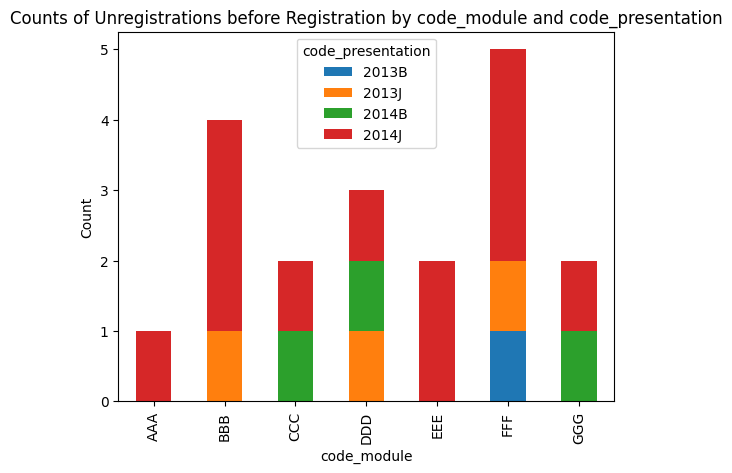

In [63]:
import matplotlib.pyplot as plt

# group  data by code_module and code_presentation, calculate the counts
grouped_counts = unreg_before_reg.groupby(['code_module', 'code_presentation']).size().unstack()

# grouped bar plot
grouped_counts.plot(kind='bar', stacked=True)
plt.xlabel('code_module')
plt.ylabel('Count')
plt.title('Counts of Unregistrations before Registration by code_module and code_presentation')
plt.legend(title='code_presentation')
plt.show()


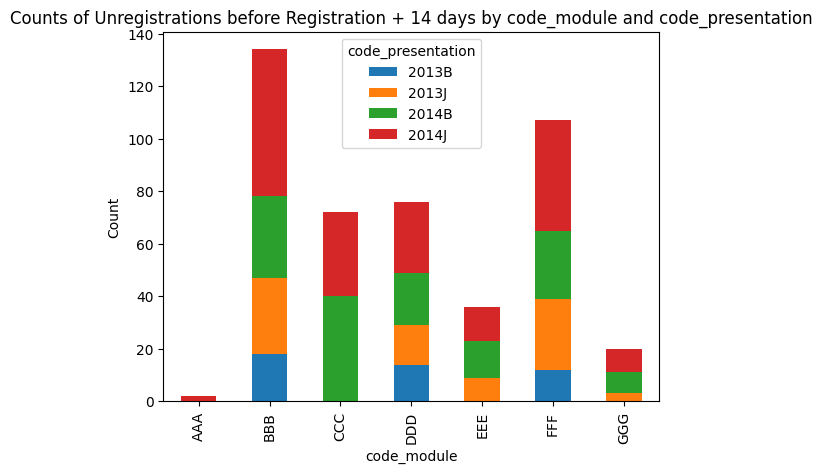

In [67]:
import matplotlib.pyplot as plt

# group  data by code_module and code_presentation, calculate the counts
grouped_counts = unreg_before_reg_14_days.groupby(['code_module', 'code_presentation']).size().unstack()

# grouped bar plot
grouped_counts.plot(kind='bar', stacked=True)
plt.xlabel('code_module')
plt.ylabel('Count')
plt.title('Counts of Unregistrations before Registration + 14 days by code_module and code_presentation')
plt.legend(title='code_presentation')
plt.show()

In [ ]:
def preprocess_data():
    # Load and merge the necessary dataframes
    index_columns = ['code_module', 'code_presentation', 'id_student']
    full_registrations = pd.merge(students, registrations, on=index_columns, validate='1:1')
    full_registrations = pd.merge(full_registrations, courses, on=['code_module', 'code_presentation'], validate='many_to_one')
    full_registrations.dropna(subset=['date_registration', 'imd_band'], inplace=True)

    # Filter out withdrawn registrations
    not_withdrawn = full_registrations['date_unregistration'].isna()
    full_registrations = full_registrations[not_withdrawn]

    # Fill missing values in 'date_unregistration' with module presentation length
    full_registrations['date_unregistration'].fillna(full_registrations['module_presentation_length'], inplace=True)

    # Filter based on 'date_unregistration' and keep only valid registrations
    full_registrations = full_registrations[full_registrations['date_unregistration'] <= full_registrations['module_presentation_length']]

    # Drop the 'date_unregistration' column
    full_registrations.drop(columns=['date_unregistration'], inplace=True)

    return full_registrations


In [ ]:
, skiprows=[128223,64073]